# Scalar MLP Training for Aerodynamic Coefficients

This notebook trains a simple Multi-Layer Perceptron (MLP) to predict scalar aerodynamic quantities directly from geometric and flow parameters.

## Methodology
1.  **Inputs:** 
    - $\alpha_{apex}$ (Apex Angle)
    - $Re$ (Reynolds Number)
    - $\sin(\alpha_0)$, $\cos(\alpha_0)$ (Angle of Attack)
2.  **Outputs:** 
    - Mean Force Coefficients: $C_D$, $C_L$, $C_M$
    - Peak Strouhal Number: $St_{peak}$
3.  **Architecture:** 3-layer MLP with 64 hidden units and Tanh activations.
4.  **Training:** 5-Fold Cross-Validation with early stopping.

> [!IMPORTANT]
> This model is trained for **Isosceles Triangles** within the following bounds:
> - $H/D \in \{1/3, 1/2, 2/3\}$
> - $Re_D \in [1.5 \times 10^6, 6.45 \times 10^6]$
> - $AoA \in [55^\circ, 125^\circ]$

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from pathlib import Path
import os
import matplotlib.pyplot as plt

# Configuration
DATA_DIR = "processed_data"
CHECKPOINT_DIR = "checkpoints_scalar"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {DEVICE}")

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 1000

Using device: mps


## 1. Dataset Definition

In [2]:
class ScalarDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## 2. Model Architecture

In [3]:
class ScalarMLP(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.net(x)

## 3. Data Loading

In [4]:
def load_data():
    npz_path = os.path.join(DATA_DIR, "improved_ml_dataset.npz")
    data = np.load(npz_path, allow_pickle=True)
    
    X = data['X'] # [alpha_apex, Re, sin_alpha0, cos_alpha0]
    y = data['y'] # [mean_cd, mean_cl, mean_cm, st_peak]
    
    # Normalize X
    X_mean = data['X_mean']
    X_std = data['X_std']
    X_norm = (X - X_mean) / X_std
    
    # Normalize y
    y_mean = np.mean(y, axis=0)
    y_std = np.std(y, axis=0)
    y_std[y_std == 0] = 1.0
    y_norm = (y - y_mean) / y_std
    
    return X_norm, y_norm, y_mean, y_std, data['case_ids']

X, y, y_mean, y_std, case_ids = load_data()
print(f"Loaded {len(X)} samples")
print(f"Features: {X.shape[1]}, Targets: {y.shape[1]}")

Loaded 75 samples
Features: 4, Targets: 4


## 4. Training with 5-Fold Cross-Validation

In [5]:
def train_scalar_model():
    # Reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # K-Fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_results = []
    fold_histories = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n--- Fold {fold+1}/5 ---")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = ScalarDataset(X_train, y_train)
        val_dataset = ScalarDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        model = ScalarMLP().to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.MSELoss()
        
        best_val_loss = float('inf')
        patience = 50
        patience_counter = 0
        history = {'train_loss': [], 'val_loss': []}
        
        for epoch in range(EPOCHS):
            model.train()
            total_loss = 0
            
            for bx, by in train_loader:
                bx, by = bx.to(DEVICE), by.to(DEVICE)
                optimizer.zero_grad()
                pred = model(bx)
                loss = criterion(pred, by)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                
            avg_train_loss = total_loss / len(train_loader)
            history['train_loss'].append(avg_train_loss)
            
            # Validation
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for bx, by in val_loader:
                    bx, by = bx.to(DEVICE), by.to(DEVICE)
                    pred = model(bx)
                    loss = criterion(pred, by)
                    total_val_loss += loss.item()
            
            avg_val_loss = total_val_loss / len(val_loader)
            history['val_loss'].append(avg_val_loss)
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"scalar_fold{fold}.pth"))
                patience_counter = 0
            else:
                patience_counter += 1
                
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.6f}")
                
            if patience_counter >= patience:
                break
        
        # Evaluate
        model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, f"scalar_fold{fold}.pth")))
        model.eval()
        
        with torch.no_grad():
            X_val_tensor = torch.FloatTensor(X_val).to(DEVICE)
            pred_norm = model(X_val_tensor).cpu().numpy()
            
        # De-normalize
        pred = pred_norm * y_std + y_mean
        y_true = y_val * y_std + y_mean
        
        # Metrics per component
        target_names = ['Cd', 'Cl', 'Cm', 'St_peak']
        fold_metrics = {}
        
        print("Fold Metrics:")
        for i, name in enumerate(target_names):
            p = pred[:, i]
            t = y_true[:, i]
            
            mse = np.mean((p - t)**2)
            r2 = 1 - np.sum((t - p)**2) / np.sum((t - np.mean(t))**2)
            
            if name == 'St_peak':
                rel_error = np.mean(np.abs(p - t) / np.abs(t))
                print(f"  {name}: R2={r2:.4f}, RelErr={rel_error*100:.2f}%")
                fold_metrics[f'{name}_RelErr'] = rel_error
            else:
                print(f"  {name}: R2={r2:.4f}")
                
            fold_metrics[f'{name}_R2'] = r2
            
        fold_results.append(fold_metrics)
        fold_histories.append(history)

    return fold_results, fold_histories

results, histories = train_scalar_model()


--- Fold 1/5 ---
Epoch 100, Val Loss: 0.283467
Epoch 200, Val Loss: 0.185620
Fold Metrics:
  Cd: R2=0.9580
  Cl: R2=0.9600
  Cm: R2=0.7999
  St_peak: R2=0.7491, RelErr=14.65%

--- Fold 2/5 ---
Epoch 100, Val Loss: 0.268169
Epoch 200, Val Loss: 0.239912
Fold Metrics:
  Cd: R2=0.9325
  Cl: R2=0.7781
  Cm: R2=0.9148
  St_peak: R2=-0.1953, RelErr=63.30%

--- Fold 3/5 ---
Epoch 100, Val Loss: 0.213036
Fold Metrics:
  Cd: R2=0.9497
  Cl: R2=0.9065
  Cm: R2=0.8135
  St_peak: R2=0.0984, RelErr=51.35%

--- Fold 4/5 ---
Epoch 100, Val Loss: 0.166603
Epoch 200, Val Loss: 0.115059
Epoch 300, Val Loss: 0.086834
Fold Metrics:
  Cd: R2=0.9951
  Cl: R2=0.8408
  Cm: R2=0.9765
  St_peak: R2=0.7903, RelErr=26.35%

--- Fold 5/5 ---
Epoch 100, Val Loss: 0.209513
Epoch 200, Val Loss: 0.126907
Epoch 300, Val Loss: 0.106396
Fold Metrics:
  Cd: R2=0.9686
  Cl: R2=0.8900
  Cm: R2=0.9621
  St_peak: R2=0.8233, RelErr=34.29%


## 5. Results Summary

In [6]:
print("\n=== Scalar Model CV Results ===")
metrics_keys = results[0].keys()
for k in metrics_keys:
    vals = [r[k] for r in results]
    print(f"{k}: {np.mean(vals):.4f} +/- {np.std(vals):.4f}")


=== Scalar Model CV Results ===
Cd_R2: 0.9608 +/- 0.0208
Cl_R2: 0.8751 +/- 0.0617
Cm_R2: 0.8934 +/- 0.0738
St_peak_RelErr: 0.3799 +/- 0.1740
St_peak_R2: 0.4532 +/- 0.4206


## 6. Visualizations

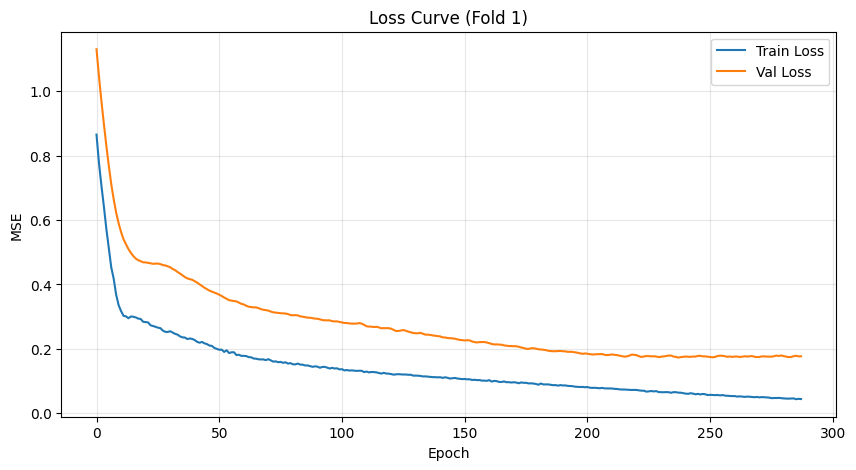

In [7]:
# 1. Loss Curves (First Fold)
plt.figure(figsize=(10, 5))
plt.plot(histories[0]['train_loss'], label='Train Loss')
plt.plot(histories[0]['val_loss'], label='Val Loss')
plt.title('Loss Curve (Fold 1)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

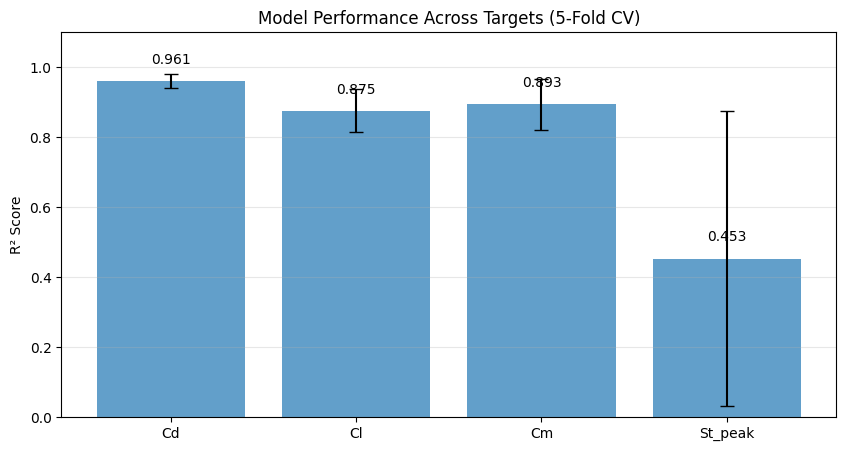

In [8]:
# 2. R² Comparison Across Targets
target_names = ['Cd', 'Cl', 'Cm', 'St_peak']
r2_means = [np.mean([r[f'{name}_R2'] for r in results]) for name in target_names]
r2_stds = [np.std([r[f'{name}_R2'] for r in results]) for name in target_names]

plt.figure(figsize=(10, 5))
plt.bar(target_names, r2_means, yerr=r2_stds, capsize=5, alpha=0.7)
plt.ylabel('R² Score')
plt.title('Model Performance Across Targets (5-Fold CV)')
plt.ylim([0, 1.1])
plt.grid(True, axis='y', alpha=0.3)
for i, (name, r2) in enumerate(zip(target_names, r2_means)):
    plt.text(i, r2 + 0.05, f'{r2:.3f}', ha='center')
plt.show()

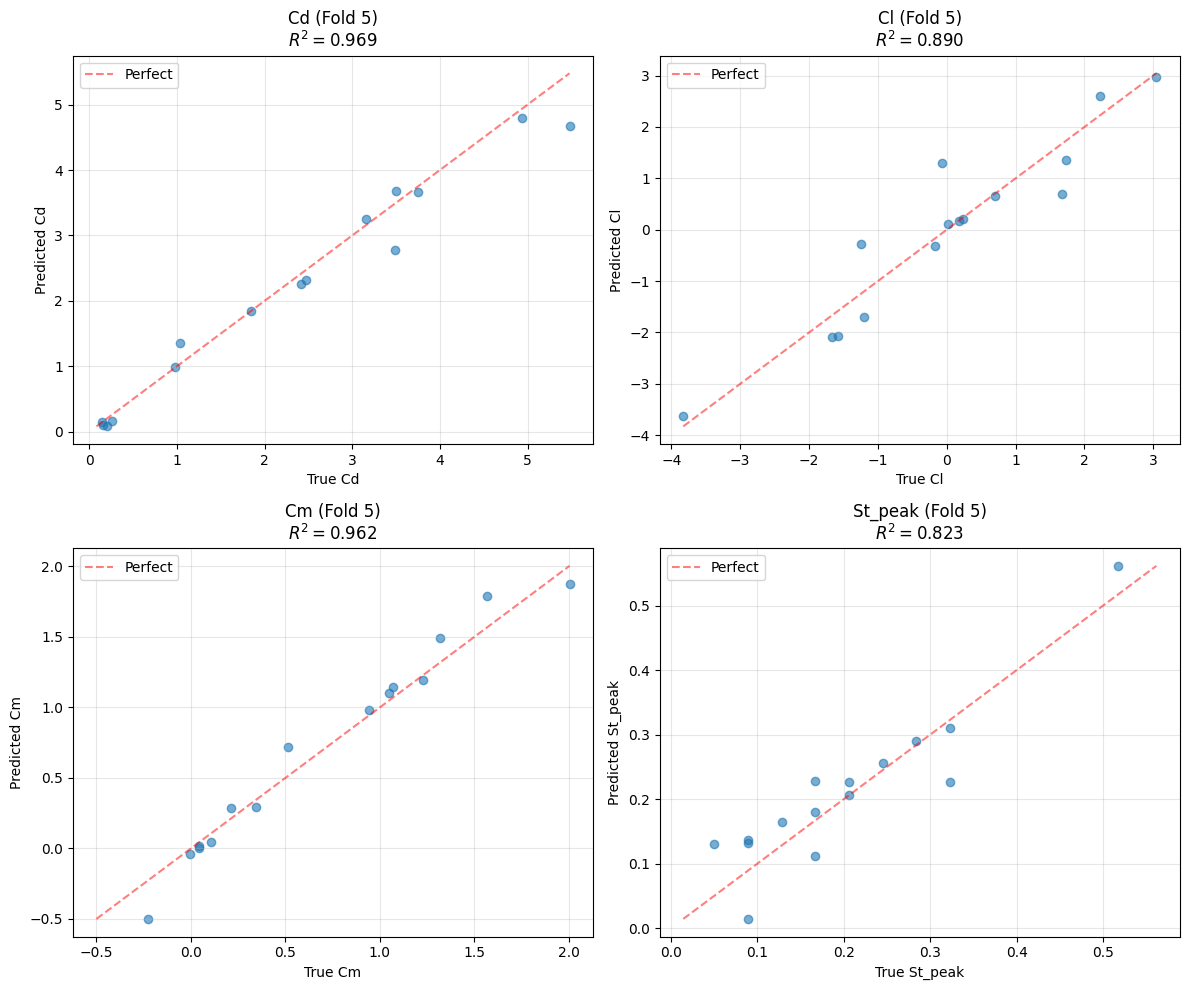

In [9]:
# 3. Prediction Scatter Plots (Last Fold)
# Reload last fold model and make predictions
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(X))
train_idx, val_idx = folds[-1]

X_val = X[val_idx]
y_val = y[val_idx]

model = ScalarMLP().to(DEVICE)
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, "scalar_fold4.pth")))
model.eval()

with torch.no_grad():
    X_val_tensor = torch.FloatTensor(X_val).to(DEVICE)
    pred_norm = model(X_val_tensor).cpu().numpy()

pred = pred_norm * y_std + y_mean
y_true = y_val * y_std + y_mean

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, name in enumerate(target_names):
    ax = axes[i]
    p = pred[:, i]
    t = y_true[:, i]
    
    ax.scatter(t, p, alpha=0.6)
    
    # Perfect prediction line
    lims = [min(t.min(), p.min()), max(t.max(), p.max())]
    ax.plot(lims, lims, 'r--', alpha=0.5, label='Perfect')
    
    r2 = 1 - np.sum((t - p)**2) / np.sum((t - np.mean(t))**2)
    ax.set_xlabel(f'True {name}')
    ax.set_ylabel(f'Predicted {name}')
    ax.set_title(f'{name} (Fold 5)\n$R^2 = {r2:.3f}$')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()